## 4 - Recurrent Neural Nets : Name Origin Classification

In [1]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import glob  #helpful in finding pathnames following specific pattern
import unicodedata
import string
import os
import random
import torch.nn.functional as F

In [2]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

### Preparing data and making its tensors

In [3]:
def findTxtFiles(path_pattern):
    return glob.glob(path_pattern)

In [4]:
path_pattern = "./rnn_data/names/*.txt"
files = findTxtFiles(path_pattern)

In [5]:
files

['./rnn_data/names/Czech.txt',
 './rnn_data/names/Dutch.txt',
 './rnn_data/names/Korean.txt',
 './rnn_data/names/Russian.txt',
 './rnn_data/names/Scottish.txt',
 './rnn_data/names/Spanish.txt',
 './rnn_data/names/Greek.txt',
 './rnn_data/names/Vietnamese.txt',
 './rnn_data/names/Irish.txt',
 './rnn_data/names/German.txt',
 './rnn_data/names/Polish.txt',
 './rnn_data/names/French.txt',
 './rnn_data/names/Portuguese.txt',
 './rnn_data/names/Chinese.txt',
 './rnn_data/names/Italian.txt',
 './rnn_data/names/Arabic.txt',
 './rnn_data/names/English.txt',
 './rnn_data/names/Japanese.txt']

In [6]:
class_list = []
word_class_dict = {}

In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)
def readTxt(file):
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for file in files:
    class_name = os.path.splitext(os.path.basename(file))[0]
    class_list.append(class_name)
    lines = readTxt(file)
    word_class_dict[class_name] = lines

In [8]:
word_class_dict['French'][:5]

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']

In [9]:
n_class = len(class_list)

In [10]:
#preparing character-wise tensor
print(all_letters.index('g'))


def letter2index(letter):
    return all_letters.index(letter)
def letter2tensor(letter):
    idx = letter2index(letter)
    x = torch.zeros(1,n_letters)
    x[0][idx]=1
    return x
def name2tensor(name):
    n_name = len(name)
    x = torch.zeros(n_name,1,n_letters)
    for i,letter in enumerate(name):
        x[i][0][letter2index(letter)]=1
    return x

6


In [11]:
name2tensor('ashish')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

### Auxillary Functions

In [25]:
def predictClass(output):
    max_val,max_idx = output.topk(1)
    class_idx = max_idx[0].item()
    return class_list[class_idx],class_idx

# give random choice index in a list
def makeRandomChoice(l):
    return random.randint(0,len(l)-1)



def makeRandomExampleTensor():
    choose_class = class_list[makeRandomChoice(class_list)]
    choose_word = word_class_dict[choose_class][makeRandomChoice(word_class_dict[choose_class])]
    y = torch.tensor([class_list.index(choose_class)],dtype=torch.long)
    X = name2tensor(choose_word)
    return choose_class,choose_word,X,y


            
def initCuda(force_cpu=True):
    ## Do check for cuda device
    if torch.cuda.is_available() and force_cpu==False:
        device = torch.device("cuda:0")
        print("GPU Process")
    elif force_cpu:
        device = torch.device("cpu")
        print("CPU Process")
    else:
        device = torch.device("cpu")
        print("CPU Process")
    return device


### RNN Architecture

In [69]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.input_size = hidden_size + input_size
        
        #Layers
        self.input_hidden = nn.Linear(self.input_size,self.hidden_size)
        self.hidden_hidden = nn.Linear(self.hidden_size,self.hidden_size)
        self.hidden_output = nn.Linear(self.hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    #forward gives us recursion by prev_hidden arguement!
    def forward(self,data, prev_hidden):
        combined = torch.cat((data,prev_hidden),1)
        hidden = self.input_hidden(combined)
        hidden = F.relu(hidden)
        hidden = self.hidden_hidden(hidden)
        hidden = F.relu(hidden)
        output = self.hidden_output(hidden)
        output = self.softmax(output)
        return output,hidden
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)
    

    
###Training Function

def train(model,n_iters):
    loss_tracker = []
    for i in range(n_iters):
        hidden = model.init_hidden()
        _,_,X,y = makeRandomExampleTensor()
        X.to(device)
        y.to(device)
        model.zero_grad()
        for j in range(X.size()[0]):
            output,hidden = model(X[j],hidden)
            output.to(device)
            hidden.to(device)
            #print(output)
            #print(y)
        loss = criterion(output,y)
        loss.backward()
        optimizer.step()
        if i%5000==0:
            loss_tracker.append(loss)    
    return loss_tracker
    

#### What's happening?
Sequence will be passed letter by letter and output will pe predicted at each time step, loss is calculated at each time step.
<img src="./images/rnn.png" height="600" width="600">


We sum up the error gradient at each time step  de/dw = <img src="./images/sum_error_grad.png">

and similarly for U and V

* Gradient wrt W will not only depend on current time step but also on prev time steps hence it is backproogation through time otherwise there is no difference between this and normal backprop used in feedforward nn.

In [76]:
device = initCuda()

CPU Process


In [77]:
hidden_size = 128
rnn = RNN(n_letters,hidden_size,n_class).to(device)
print(rnn)

RNN(
  (input_hidden): Linear(in_features=185, out_features=128, bias=True)
  (hidden_hidden): Linear(in_features=128, out_features=128, bias=True)
  (hidden_output): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


In [78]:
import torch.optim as optim
optimizer = optim.Adam(rnn.parameters(),lr=0.00025)
criterion = nn.NLLLoss()


In [79]:
loss_plot = train(rnn,50000)

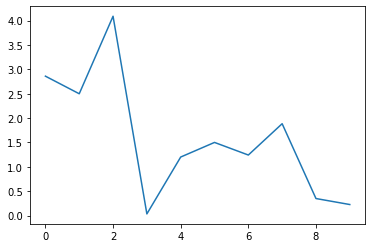

In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.plot(loss_plot)
plt.show()

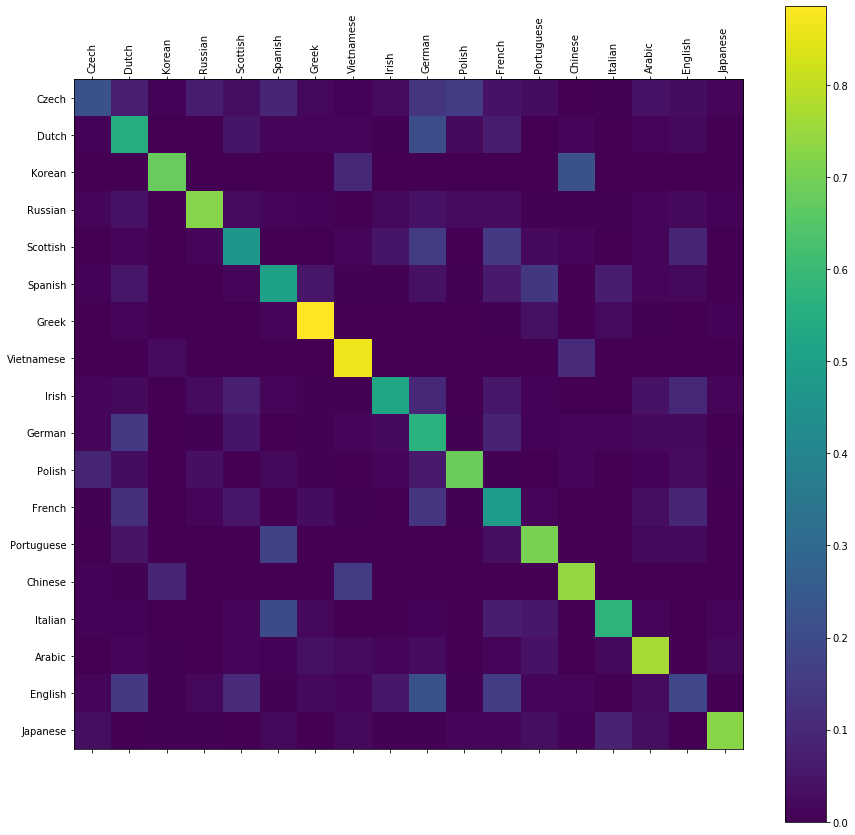

In [81]:
# Copied as it is from 60 min blitz
confusion = torch.zeros(n_class, n_class)
n_confusion = 10000
all_categories=class_list
n_categories = n_class
# Just return an output given a line
def evaluate(line_tensor):
    with torch.no_grad():
        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, line_tensor,category_tensor = makeRandomExampleTensor()
    #print(line_tensor)
    output = evaluate(line_tensor)
    guess, guess_i = predictClass(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()